# Текстовые эмбеддинги

Будем рассматривать задачу классификации текстов на 2 категории: исполняемые Киркоровым и исполняемые Монеточкой. Для работы с текстами нам понадобятся несколько дополнительных библиотек:
* nltk - большая библиотека, в которой содержится множество полезных функций для обработки текста, такие, как, например, удаление пунктуации, стемминг и лемматизацию
* snowballstemmer - стеммер для русского языка
* pymorphy2, pymystem3 - морфоанализаторы для русского языка
* gensim - библиотека, содержащая модели текстовых эмбеддингов

In [15]:
!pip install gensim

  Created wheel for smart-open: filename=smart_open-1.9.0-cp37-none-any.whl size=73092 sha256=49a31a827584bbe940fc2be21ff080383ec537fc69936360c428607d46afb078
  Stored in directory: C:\Users\Alu\AppData\Local\pip\Cache\wheels\ab\10\93\5cff86f5b721d77edaecc29959b1c60d894be1f66d91407d28
Successfully built smart-open


In [1]:
import nltk
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
from pandas import read_csv
import pandas as pd
import numpy as np
import sklearn
from sklearn import svm
from string import punctuation
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.metrics import accuracy_score, precision_score, recall_score,precision_recall_curve, roc_auc_score, f1_score, fbeta_score, auc
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import MiniBatchKMeans
import re, nltk, spacy, gensim
from sklearn.decomposition import PCA
try:
    import os
    os.chdir('/home/disco/venv/')
except ImportError:
    pass
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /home/disco/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/disco/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/disco/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## Предобработка текстов

Поскольку в русском языке много словоформ, прежде всего нужно преобразовать все тексты к единому виду.

Считаем один из файлов и посмотрим, что мы можем с ним сделать

In [4]:
out = read_csv("corp3.csv", sep=',', header=0)
out

,article,category
0,Jony Ive speaks onstage during the 2017 New Yo...,gadgets
1,Healthcare worker sets up an EEG on an ICU pat...,science
2,June was a busy month for Mac malware with the...,IT
3,A Renault Captur in more idealistic conditions...,cars
4,This story isn't really about this kind of cha...,science
...,...,...
5947,"My Late, Great Chevy Impala The first two mach...",cars
5948,Even when the instrument cluster is in navigat...,cars
5949,Chevrolet Chevrolet provided flights to North...,cars
5950,Boring Company Elon Musk's Boring Company is ...,cars


In [5]:
lem = WordNetLemmatizer()
stop_words=set(stopwords.words("english"))

def stop(value):
    filtered_sent=[]
    tokenized_sent=word_tokenize(value)
    for w in tokenized_sent:
        if w not in stop_words and w not in punctuation:
            filtered_sent.append(lem.lemmatize(w,"v"))
    return ' '.join(filtered_sent).lower()

out['article']=out['article'].apply(stop)

In [6]:
out

,article,category
0,jony ive speak onstage 2017 new yorker techfes...,gadgets
1,healthcare worker set eeg icu patient getty bs...,science
2,june busy month mac malware active circulation...,IT
3,a renault captur idealistic condition renault ...,cars
4,this story n't really kind chameleon sorry ren...,science
...,...,...
5947,my late great chevy impala the first two machi...,cars
5948,even instrument cluster navigation mode traffi...,cars
5949,chevrolet chevrolet provide flight north carol...,cars
5950,boring company elon musk 's boring company nea...,cars


In [7]:
from sklearn import preprocessing
data = pd.DataFrame(columns=['article', 'category'])
data['article']=out['article']
le = preprocessing.LabelEncoder()
le.fit(out['category'])
data['category'] = le.transform(out['category'])

## Формирование выборки сырых данных

Обернем наши предыдущие действия в функцию:

In [ ]:
pf = read_csv("Lemmatized_corps4.csv", sep=',', header=0)
pf.drop('Unnamed: 0', axis='columns')

In [60]:
pf = read_csv("Lemmatized_corps.csv", sep=',', header=0).drop('Unnamed: 0', axis='columns')
pf.columns=['article','categorie']

In [4]:
def remove(sent):
    return re.sub("\'", "", re.sub('\s+', ' ', re.sub('\S*@\S*\s?', '', sent)))

In [5]:
pf = read_csv("11k_20t.csv", sep=',', header=0).drop('Unnamed: 0', axis='columns')
pf.content.apply(remove)

0        From: (wheres my thing) Subject: WHAT car is t...
1        From: (Guy Kuo) Subject: SI Clock Poll - Final...
2        From: (Thomas E Willis) Subject: PB questions....
3        From: (Joe Green) Subject: Re: Weitek P9000 ? ...
4        From: (Jonathan McDowell) Subject: Re: Shuttle...
                               ...                        
11309    From: (Jim Zisfein) Subject: Re: Migraines and...
11310    From: Subject: Screen Death: Mac Plus/512 Line...
11311    From: (Will Estes) Subject: Mounting CPU Coole...
11312    From: (Steven Collins) Subject: Re: Sphere fro...
11313    From: (Kevin J. Gunning) Subject: stolen CBR90...
Name: content, Length: 11314, dtype: object

In [6]:
pf.columns=['article','categorie','category']
pf

,article,categorie,category
0,From: lerxst@wam.umd.edu (where's my thing)\nS...,7,rec.autos
1,From: guykuo@carson.u.washington.edu (Guy Kuo)...,4,comp.sys.mac.hardware
2,From: twillis@ec.ecn.purdue.edu (Thomas E Will...,4,comp.sys.mac.hardware
3,From: jgreen@amber (Joe Green)\nSubject: Re: W...,1,comp.graphics
4,From: jcm@head-cfa.harvard.edu (Jonathan McDow...,14,sci.space
...,...,...,...
11309,From: jim.zisfein@factory.com (Jim Zisfein) \n...,13,sci.med
11310,From: ebodin@pearl.tufts.edu\nSubject: Screen ...,4,comp.sys.mac.hardware
11311,From: westes@netcom.com (Will Estes)\nSubject:...,3,comp.sys.ibm.pc.hardware
11312,From: steve@hcrlgw (Steven Collins)\nSubject: ...,1,comp.graphics


Разобьем выборку на трейн и тест

In [61]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(pf['article'], pf['categorie'], test_size=0.33, stratify=pf['categorie'])

In [62]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vect = TfidfVectorizer()
tfidf_vect.fit(pf['article'])
tfidf_train = tfidf_vect.transform(X_train)
tfidf_test = tfidf_vect.transform(X_test)

In [63]:
from sklearn.cluster import MiniBatchKMeans
from sklearn.decomposition import PCA
cls = MiniBatchKMeans(n_clusters=10, random_state=13)
cls.fit(tfidf_test)

MiniBatchKMeans(batch_size=100, compute_labels=True, init='k-means++',
                init_size=None, max_iter=100, max_no_improvement=10,
                n_clusters=10, n_init=3, random_state=13,
                reassignment_ratio=0.01, tol=0.0, verbose=0)

In [64]:
# predict cluster labels for new dataset
cls.predict(tfidf_train)

# to get cluster labels for the dataset used while
# training the model (used for models that does not
# support prediction on new dataset).
cls.labels_


array([8, 8, 1, ..., 1, 4, 1], dtype=int32)

In [65]:
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

svd = TruncatedSVD(2)
normalizer = Normalizer(copy=False)
lsa = make_pipeline(svd, normalizer)
reduced_features = lsa.fit_transform(tfidf_train)

# reduce the cluster centers to 2D
reduced_cluster_centers = lsa.transform(cls.cluster_centers_)

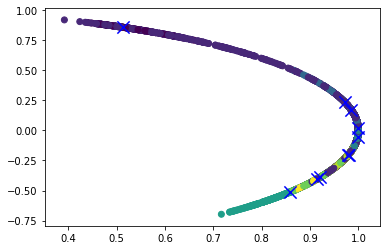

In [66]:
c=cls.predict(tfidf_train)
plt.scatter(reduced_features[:,0], reduced_features[:,1], c=c)
plt.scatter(reduced_cluster_centers[:, 0], reduced_cluster_centers[:,1], marker='x', s=150, c='b')

In [28]:
from sklearn.metrics import homogeneity_score, completeness_score, adjusted_rand_score
print(homogeneity_score(y_train, c))
print(completeness_score(y_train, c))
print(adjusted_rand_score(y_train, c))

0.07827127218068512
0.23993149069277528
0.0204942773392507


In [29]:
from sklearn.metrics.cluster import contingency_matrix
contingency_matrix(y_train, c)

array([[ 55,   0,   0, 179,   0,   0,   0,  88,   0,   0],
       [  0,  26,   0,  50,   0,   0,   1, 314,   0,   0],
       [  0,  71,   0,  38,   0,   0,   3, 284,   0,   0],
       [  0, 102,   0,  43,   0,   0,   0, 249,   1,   0],
       [  0,  32,   0,  82,   0,   0,   0, 273,   0,   0],
       [  0,  35,   0,  50,   0,   0,   0, 312,   0,   0],
       [  0,   6,   0,  26,   0,   0,   0, 360,   0,   0],
       [  0,   1,   0, 171,   0,   1,   0, 225,   0,   0],
       [  0,   0,   0, 138,   0,   0,   0, 263,   0,   0],
       [  0,   0,   0, 147,   0,   0,   0, 253,   0,   0],
       [  0,   1,   0, 171,   0,   0,   0, 230,   0,   0],
       [  0,   2,   0, 216,   0,  57,   0, 124,   0,   0],
       [  0,  10,   0, 102,   0,   0,   0, 284,   0,   0],
       [  0,  56,   0, 147,   0,   0,   0, 195,   0,   0],
       [  0,   0,   0, 156,   0,   0,   0, 241,   0,   0],
       [  0,   0,   3, 314,   0,   0,   0,  84,   0,   0],
       [  0,   0,   0, 245,   0,   0,   0, 121,   0,   0

In [31]:
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn import metrics

from sklearn.cluster import KMeans, MiniBatchKMeans

print("%d documents" % len(pf.article))
print("%d categories" % len(pf.categorie))
print()

labels = pf.categorie
true_k = np.unique(labels).shape[0]

print("Extracting features from the training dataset "
      "using a sparse vectorizer")

u = 2
y = 1
true_k =20


if u==1:
    if y==1:
        # Perform an IDF normalization on the output of HashingVectorizer
        hasher = HashingVectorizer(stop_words='english', alternate_sign=False,
                                   norm=None)
        vectorizer = make_pipeline(hasher, TfidfTransformer())
    else:
        vectorizer = HashingVectorizer(stop_words='english',
                                       alternate_sign=False, norm='l2')
else:
    vectorizer = TfidfVectorizer(max_df=0.5, min_df=2, stop_words='english',
                                 use_idf=1)
X = vectorizer.fit_transform(pf.article)

print("n_samples: %d, n_features: %d" % X.shape)
print()

if u==1:
    print("Performing dimensionality reduction using LSA")
    # Vectorizer results are normalized, which makes KMeans behave as
    # spherical k-means for better results. Since LSA/SVD results are
    # not normalized, we have to redo the normalization.
    svd = TruncatedSVD(100)
    normalizer = Normalizer(copy=False)
    lsa = make_pipeline(svd, normalizer)

    X = lsa.fit_transform(X)

    explained_variance = svd.explained_variance_ratio_.sum()
    print("Explained variance of the SVD step: {}%".format(
        int(explained_variance * 100)))

    print()


# #############################################################################
# Do the actual clustering

if u == 1:
    km = MiniBatchKMeans(n_clusters=true_k, init='k-means++', n_init=1,
                         init_size=1000, batch_size=1000)
else:
    km = KMeans(n_clusters=true_k, init='k-means++', max_iter=100, n_init=1)

print("Clustering sparse data with %s" % km)
km.fit(X)
print()

print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels, km.labels_))
print("Completeness: %0.3f" % metrics.completeness_score(labels, km.labels_))
print("V-measure: %0.3f" % metrics.v_measure_score(labels, km.labels_))
print("Adjusted Rand-Index: %.3f"
      % metrics.adjusted_rand_score(labels, km.labels_))
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X, km.labels_, sample_size=1000))

11314 documents
11314 categories

Extracting features from the training dataset using a sparse vectorizer
n_samples: 11314, n_features: 56121

Clustering sparse data with KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=100,
       n_clusters=20, n_init=1, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

Homogeneity: 0.344
Completeness: 0.417
V-measure: 0.377
Adjusted Rand-Index: 0.126
Silhouette Coefficient: 0.006


In [32]:
print("Top terms per cluster:")

if u==1:
    original_space_centroids = svd.inverse_transform(km.cluster_centers_)
    order_centroids = original_space_centroids.argsort()[:, ::-1]
else:
    order_centroids = km.cluster_centers_.argsort()[:, ::-1]

terms = vectorizer.get_feature_names()
for i in range(true_k):
    print("Cluster %d:" % i, end='')
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind], end='')
    print()

Top terms per cluster:
Cluster 0: god jesus christians bible people christian faith christ believe church
Cluster 1: team game ca players hockey year games season play baseball
Cluster 2: windows window file dos files program com use ms help
Cluster 3: drive scsi card ide bus controller cleveland disk video drives
Cluster 4: uk ac university cam mathew dcs ed mantis posting host
Cluster 5: cs hp com colorado cmu sun andrew posting host nntp
Cluster 6: israel people gun israeli government com jews guns don think
Cluster 7: nasa gov space msg jpl food larc jsc baalke gsfc
Cluster 8: washington wpi jake polygon carson seattle article shelley bony1 bony
Cluster 9: columbia gld cunixb cc dare gary keenan cunixa insurance pgf5
Cluster 10: geb banks gordon pitt cs dsl n3jxp chastity cadre shameful
Cluster 11: sale apple 00 mac monitor cd offer university simms new
Cluster 12: car com bike henry article cars just dod toronto ca
Cluster 13: uiuc cso stratus illinois urbana sw cdt uxa com news
C

In [33]:
contingency_matrix(labels, km.labels_)

array([[107,   0,   0,   0,  32,  16,  26,   1,   4,   0,   0,   0,   0,
         16,   0, 107,   0,   0, 171,   0],
       [  1,   0, 139,  27,  49,  23,   0,  12,  34,   2,   0,  29,   3,
          6,   0,   1,   0,   2, 251,   5],
       [  0,   0, 339,  51,  27,  28,   0,   1,   2,   0,   0,  13,   2,
          7,  10,   0,   0,   0, 109,   2],
       [  0,   1,  41, 269,  15,  32,   0,   4,   7,   1,   0,  45,   6,
          5,   0,   0,   0,   0, 162,   2],
       [  0,   0,   5,  73,  18,  32,   0,   8,  13,   2,   0, 291,   0,
          8,   0,   0,   0,   7, 119,   2],
       [  0,   0, 193,   4,  61,  55,   0,  15,   1,   1,   0,   2,   0,
          0,   0,   0,   3,   2, 252,   4],
       [  0,   7,   8,  41,   3,  30,   0,   3,  13,   5,   0, 313,  19,
          8,   0,   0,   0,  19, 109,   7],
       [  0,   0,   3,   1,   6,  35,   0,   1,  15,   1,   0,   5, 359,
         25,   0,   1,   0,  21, 119,   2],
       [  0,   0,   0,   3,  46,  76,   0,  15,   4,   6,   0,  

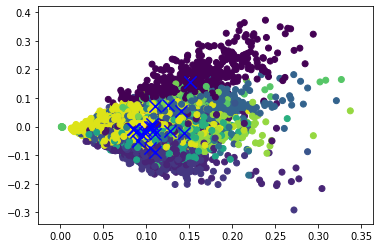

In [34]:
pca = TruncatedSVD(n_components=2, n_iter=7, random_state=42)
reduced_features = pca.fit_transform(X)

# reduce the cluster centers to 2D
reduced_cluster_centers = pca.transform(km.cluster_centers_)
c=km.predict(X)
plt.scatter(reduced_features[:,0], reduced_features[:,1], c=c)
plt.scatter(reduced_cluster_centers[:, 0], reduced_cluster_centers[:,1], marker='x', s=150, c='b')

In [36]:
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn import metrics

from sklearn.cluster import KMeans, MiniBatchKMeans

print("%d documents" % len(pf.article))
print("%d categories" % len(pf.category))
print()

labels = pf.category
true_k = np.unique(labels).shape[0]

print("Extracting features from the training dataset "
      "using a sparse vectorizer")

u = 1
y = 1
true_k =20


if u==1:
    if y==1:
        # Perform an IDF normalization on the output of HashingVectorizer
        hasher = HashingVectorizer(stop_words='english', alternate_sign=False,
                                   norm='l2')
        vectorizer = TfidfTransformer()
    else:
        vectorizer = HashingVectorizer(stop_words='english',
                                       alternate_sign=False, norm='l1')
else:
    vectorizer = TfidfVectorizer(max_df=0.5, min_df=2, stop_words='english',
                                 use_idf=1)
X = vectorizer.fit_transform(hasher.fit_transform(pf.article))

print("n_samples: %d, n_features: %d" % X.shape)
print()

if u==1:
    print("Performing dimensionality reduction using LSA")
    # Vectorizer results are normalized, which makes KMeans behave as
    # spherical k-means for better results. Since LSA/SVD results are
    # not normalized, we have to redo the normalization.
    svd = TruncatedSVD(150)
    normalizer = Normalizer(copy=False)
    lsa = make_pipeline(svd, normalizer)

    X = lsa.fit_transform(X)

    explained_variance = svd.explained_variance_ratio_.sum()
    print("Explained variance of the SVD step: {}%".format(
        int(explained_variance * 100)))

    print()


# #############################################################################
# Do the actual clustering

if u == 1:
    km = MiniBatchKMeans(n_clusters=true_k, init='k-means++', n_init=1,
                         init_size=1000, batch_size=1000)
else:
    km = KMeans(n_clusters=true_k, init='k-means++', max_iter=1000, n_init=1)

print("Clustering sparse data with %s" % km)
km.fit(X)
print()

print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels, km.labels_))
print("Completeness: %0.3f" % metrics.completeness_score(labels, km.labels_))
print("V-measure: %0.3f" % metrics.v_measure_score(labels, km.labels_))
print("Adjusted Rand-Index: %.3f"
      % metrics.adjusted_rand_score(labels, km.labels_))
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X, km.labels_, sample_size=1000))

11314 documents
11314 categories

Extracting features from the training dataset using a sparse vectorizer
n_samples: 11314, n_features: 1048576

Performing dimensionality reduction using LSA
Explained variance of the SVD step: 14%

Clustering sparse data with MiniBatchKMeans(batch_size=1000, compute_labels=True, init='k-means++',
                init_size=1000, max_iter=100, max_no_improvement=10,
                n_clusters=20, n_init=1, random_state=None,
                reassignment_ratio=0.01, tol=0.0, verbose=0)

Homogeneity: 0.351
Completeness: 0.388
V-measure: 0.368
Adjusted Rand-Index: 0.193
Silhouette Coefficient: 0.054


In [37]:
from sklearn.metrics.cluster import contingency_matrix
contingency_matrix(labels, km.labels_)

array([[ 10,   0,  19,  40,  23,   1,   0, 119,   0,   5,  29, 165,   0,
          1,   1,   0,   0,  13,   0,  54],
       [ 33,   3, 115,   0,  31,  25,   5,   3,   4,   7,  84,   0,   0,
         15,   0,   2,   2,  12,   0, 243],
       [ 21,  11, 135,   0,  11,   3,  10,   1,   1,   3,  74,   0,   0,
          5,   0,  16,   4,  13,   1, 282],
       [ 28,   2,  89,   0,  16,  63,   9,   0,   0,   7,  48,   0,   2,
         11,   0, 178,   2,   6,   1, 128],
       [ 17,   5,  22,   1,  10, 333,   4,   1,   2,   6,  18,   0,   0,
          9,   0,  54,   3,   9,   1,  83],
       [ 24,   4, 310,   1,   8,  11,   3,   0,  11,   1,  65,   0,   0,
         21,   0,   1,   8,   1,  11, 113],
       [ 13,  10,  46,   1,  28,  10, 321,   1,   9,   5,   4,   0,   3,
          3,   0,  37,   2,   4,   0,  88],
       [ 10,   5,  81,  12,  31,   1,   6,   2,  17, 301,   6,   0,   0,
          3,   0,   3,   6,  26,   0,  84],
       [ 18,  11, 147,  21,  17,   4,  63,   2,  12, 104,  48,  

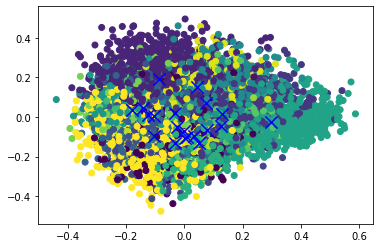

In [38]:
pca = PCA(n_components=2, random_state=13)
reduced_features = pca.fit_transform(X)

# reduce the cluster centers to 2D
reduced_cluster_centers = pca.transform(km.cluster_centers_)
c=km.predict(X)
plt.scatter(reduced_features[:,0], reduced_features[:,1], c=c)
plt.scatter(reduced_cluster_centers[:, 0], reduced_cluster_centers[:,1], marker='x', s=150, c='b')

## Word2vec-эмбеддинг
Поскольку w2v - это не sklearn'овский классификатор, он на выходе выдаст данные немного другого вида, и это надо будет учитывать в дальнейшей работе

In [42]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(pf['article'], 
                                                    pf['categorie'], 
                                                    test_size=0.33)
from gensim.models import Word2Vec
X_w2v = pf['article'].apply(str.split)
model = Word2Vec(X_w2v, size=600, min_count=10, workers=8)
def text2vec(text):
    """Усредняем векторы слов"""
    vecs = []
    for word in text:
        try:
            vecs.append(model[word])
        except KeyError:
            pass
    return np.sum(vecs, axis=0) / len(vecs)

w2v_total = X_w2v.apply(text2vec)
w2v_total = np.dstack(w2v_total)[0]
w2v_total = np.dstack(w2v_total)[0]

/home/disco/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  del sys.path[0]


In [43]:
from gensim.models import Word2Vec
X_train_w2v = X_train.apply(str.split)
X_test_w2v = X_test.apply(str.split)
w2v_vect = Word2Vec(np.hstack([X_train_w2v, X_test_w2v]), size=300, min_count=10, workers=8)

In [45]:
X_w2v = pf['article'].apply(str.split)
model = Word2Vec(X_w2v, size=300, min_count=10, workers=8)

In [46]:
def text2vec(text):
    """Усредняем векторы слов"""
    vecs = []
    for word in text:
        try:
            vecs.append(w2v_vect[word])
        except KeyError:
            pass
    return np.sum(vecs, axis=0) / len(vecs)

w2v_train = X_train_w2v.apply(text2vec)
w2v_test = X_test_w2v.apply(text2vec)

/home/disco/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


In [47]:
w2v_train = np.dstack(w2v_train)[0]
w2v_train = np.dstack(w2v_train)[0]
w2v_test = np.dstack(w2v_test)[0]
w2v_test = np.dstack(w2v_test)[0]

In [48]:
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn import metrics

from sklearn.cluster import KMeans, MiniBatchKMeans

labels = y_train
true_k = np.unique(labels).shape[0]

print("Extracting features from the training dataset "
      "using a sparse vectorizer")

u = 1
y = 1
true_k =20

X = w2v_train

print("n_samples: %d, n_features: %d" % X.shape)
print()

if u==1:
    print("Performing dimensionality reduction using LSA")
    # Vectorizer results are normalized, which makes KMeans behave as
    # spherical k-means for better results. Since LSA/SVD results are
    # not normalized, we have to redo the normalization.
    svd = TruncatedSVD(150)
    normalizer = Normalizer(copy=False)
    lsa = make_pipeline(svd, normalizer)

    X = lsa.fit_transform(X)
    Xt = lsa.fit_transform(w2v_test)

    explained_variance = svd.explained_variance_ratio_.sum()
    print("Explained variance of the SVD step: {}%".format(
        int(explained_variance * 100)))

    print()


# #############################################################################
# Do the actual clustering

if u == 1:
    km = MiniBatchKMeans(n_clusters=true_k, init='k-means++', n_init=1,
                         init_size=1000, batch_size=1000)
else:
    km = KMeans(n_clusters=true_k, init='k-means++', max_iter=1000, n_init=1)

print("Clustering sparse data with %s" % km)
km.fit(X)
print()

print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels, km.labels_))
print("Completeness: %0.3f" % metrics.completeness_score(labels, km.labels_))
print("V-measure: %0.3f" % metrics.v_measure_score(labels, km.labels_))
print("Adjusted Rand-Index: %.3f"
      % metrics.adjusted_rand_score(labels, km.labels_))
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X, km.labels_, sample_size=1000))

Extracting features from the training dataset using a sparse vectorizer
n_samples: 7580, n_features: 300

Performing dimensionality reduction using LSA
Explained variance of the SVD step: 99%

Clustering sparse data with MiniBatchKMeans(batch_size=1000, compute_labels=True, init='k-means++',
                init_size=1000, max_iter=100, max_no_improvement=10,
                n_clusters=20, n_init=1, random_state=None,
                reassignment_ratio=0.01, tol=0.0, verbose=0)

Homogeneity: 0.152
Completeness: 0.161
V-measure: 0.156
Adjusted Rand-Index: 0.057
Silhouette Coefficient: 0.048


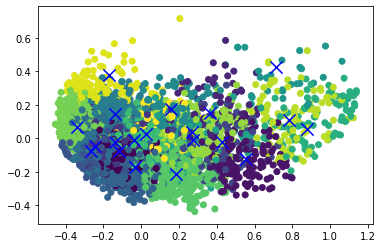

In [49]:
pca = PCA(n_components=2, random_state=13)
reduced_features = pca.fit_transform(Xt)

# reduce the cluster centers to 2D
reduced_cluster_centers = pca.transform(km.cluster_centers_)
c=km.predict(Xt)
plt.scatter(reduced_features[:,0], reduced_features[:,1], c=c)
plt.scatter(reduced_cluster_centers[:, 0], reduced_cluster_centers[:,1], marker='x', s=150, c='b')

## Bag-of-Words-эмбеддинг

In [50]:
from sklearn.feature_extraction.text import CountVectorizer
bow_vect = CountVectorizer()
bow_vect.fit(pf['article'])
bow_train = bow_vect.transform(X_train)
bow_test = bow_vect.transform(X_test)

In [51]:
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn import metrics

from sklearn.cluster import KMeans, MiniBatchKMeans

labels = y_train
true_k = np.unique(labels).shape[0]

print("Extracting features from the training dataset "
      "using a sparse vectorizer")

u = 1
y = 1
true_k =5

X = bow_train

print("n_samples: %d, n_features: %d" % X.shape)
print()

if u==1:
    print("Performing dimensionality reduction using LSA")
    # Vectorizer results are normalized, which makes KMeans behave as
    # spherical k-means for better results. Since LSA/SVD results are
    # not normalized, we have to redo the normalization.
    svd = TruncatedSVD(150)
    normalizer = Normalizer(copy=False)
    lsa = make_pipeline(svd, normalizer)

    X = lsa.fit_transform(X)
    Xt = lsa.fit_transform(bow_test)

    explained_variance = svd.explained_variance_ratio_.sum()
    print("Explained variance of the SVD step: {}%".format(
        int(explained_variance * 100)))

    print()


# #############################################################################
# Do the actual clustering

if u == 1:
    km = MiniBatchKMeans(n_clusters=true_k, init='k-means++', n_init=1,
                         init_size=1000, batch_size=1000)
else:
    km = KMeans(n_clusters=true_k, init='k-means++', max_iter=1000, n_init=1)

print("Clustering sparse data with %s" % km)
km.fit(X)
print()

print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels, km.labels_))
print("Completeness: %0.3f" % metrics.completeness_score(labels, km.labels_))
print("V-measure: %0.3f" % metrics.v_measure_score(labels, km.labels_))
print("Adjusted Rand-Index: %.3f"
      % metrics.adjusted_rand_score(labels, km.labels_))
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X, km.labels_, sample_size=1000))

Extracting features from the training dataset using a sparse vectorizer
n_samples: 7580, n_features: 130107

Performing dimensionality reduction using LSA
Explained variance of the SVD step: 99%

Clustering sparse data with MiniBatchKMeans(batch_size=1000, compute_labels=True, init='k-means++',
                init_size=1000, max_iter=100, max_no_improvement=10,
                n_clusters=5, n_init=1, random_state=None,
                reassignment_ratio=0.01, tol=0.0, verbose=0)

Homogeneity: 0.031
Completeness: 0.059
V-measure: 0.040
Adjusted Rand-Index: 0.014
Silhouette Coefficient: 0.015


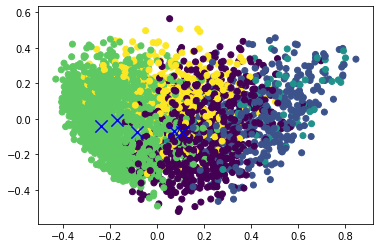

In [52]:
pca = PCA(n_components=2, random_state=13)
reduced_features = pca.fit_transform(Xt)

# reduce the cluster centers to 2D
reduced_cluster_centers = pca.transform(km.cluster_centers_)
c=km.predict(Xt)
plt.scatter(reduced_features[:,0], reduced_features[:,1], c=c)
plt.scatter(reduced_cluster_centers[:, 0], reduced_cluster_centers[:,1], marker='x', s=150, c='b')